In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import preprocess_input, decode_predictions

import tensorflow as tf
tf.keras.applications.inception_v3.preprocess_input
from tensorflow.keras.applications import DenseNet169,MobileNet,NASNetMobile,Xception,InceptionV3
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [2]:
disease_types=['normal', 'abnormal']
data_dir = 'F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,normal/ABERSCIO_4CH_65.jpg,0,normal
1,normal/ABERSCIO_4CH_66.jpg,0,normal
2,normal/ABERSCIO_4CH_67.jpg,0,normal
3,normal/ABERSCIO_4CH_68.jpg,0,normal
4,normal/ABERSCIO_4CH_69.jpg,0,normal


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,normal/BYSMA PRATA UTAMA (NORMAL)5CH_108.jpg,0,normal
1,abnormal/NAILA_SHORT_AXIS_74.jpg,1,abnormal
2,normal/NADIRA_5CH_74.jpg,0,normal
3,abnormal/alif_shortaxis_52.jpg,1,abnormal
4,normal/AYYUB_5CH_22.jpg,0,normal


In [5]:
print (train)

                                               File  DiseaseID Disease Type
0      normal/BYSMA PRATA UTAMA (NORMAL)5CH_108.jpg          0       normal
1                  abnormal/NAILA_SHORT_AXIS_74.jpg          1     abnormal
2                          normal/NADIRA_5CH_74.jpg          0       normal
3                    abnormal/alif_shortaxis_52.jpg          1     abnormal
4                           normal/AYYUB_5CH_22.jpg          0       normal
...                                             ...        ...          ...
4065                      normal/KALIKA_5CH_108.jpg          0       normal
4066               normal/KHALISAH_SUBCOSTAL_48.jpg          0       normal
4067             normal/DIRGANTARA_LONG_AXIS_15.jpg          0       normal
4068                         abnormal/M_RAFA_31.jpg          1     abnormal
4069  abnormal/HARIS_ALHAFIZ_MOD2_LONG_AXIS_134.jpg          1     abnormal

[4070 rows x 3 columns]


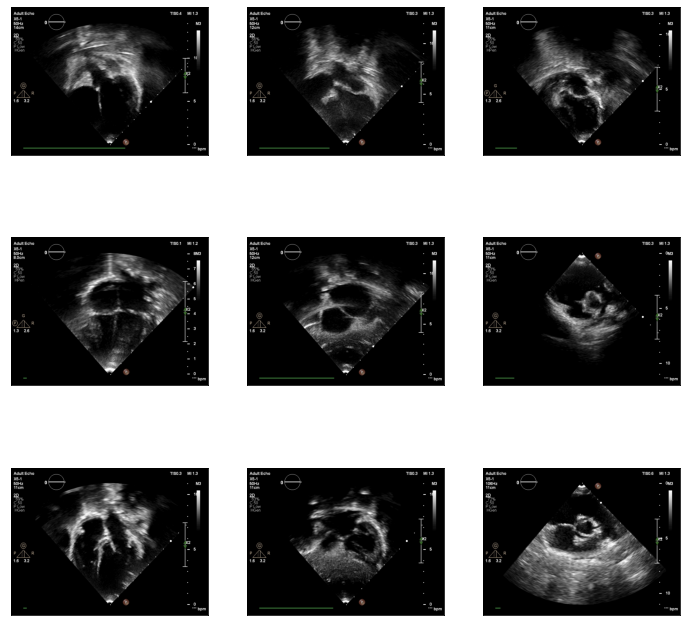

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('normal', 3, 3)

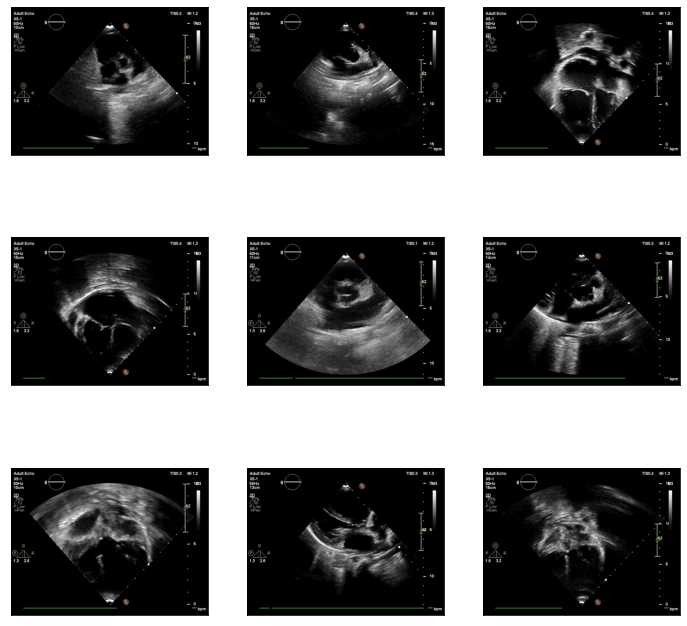

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('abnormal', 3, 3)

In [8]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

4070it [01:10, 57.59it/s]


Train Shape: (4070, 64, 64, 3)


In [10]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(4070, 2)


In [11]:
BATCH_SIZE = 16

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)


In [12]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (3256, 64, 64, 3)
X_val: (814, 64, 64, 3)
Y_train: (3256, 2)
Y_val: (814, 2)


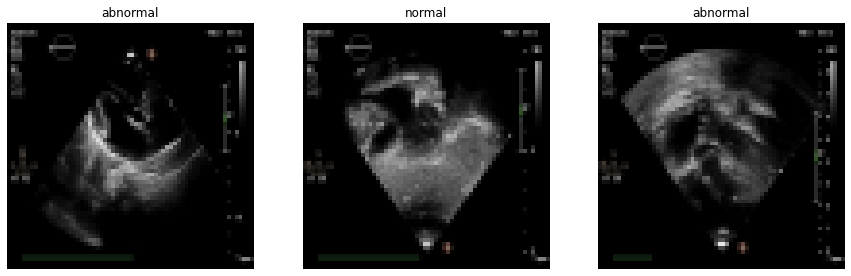

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [14]:
EPOCHS = 200
SIZE=64
N_ch=3

In [15]:
def build_resnet50():
    resnet50 = ResNet50(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = resnet50(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
model = build_resnet50()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_resnet50_1802_b16_new.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544

In [17]:
# from keras.utils import plot_model
# from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

In [18]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
202/203 [============================>.] - ETA: 0s - loss: 1.1852 - accuracy: 0.5251
Epoch 00001: val_loss improved from inf to 1.09043, saving model to model_resnet50_1802_b16_new.h5
203/203 [==============================] - 10s 51ms/step - loss: 1.1836 - accuracy: 0.5256 - val_loss: 1.0904 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 2/200
203/203 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.5401
Epoch 00002: val_loss improved from 1.09043 to 0.87516, saving model to model_resnet50_1802_b16_new.h5
203/203 [==============================] - 8s 42ms/step - loss: 1.0092 - accuracy: 0.5401 - val_loss: 0.8752 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 3/200
202/203 [============================>.] - ETA: 0s - loss: 0.8833 - accuracy: 0.5450
Epoch 00003: val_loss improved from 0.87516 to 0.68050, saving model to model_resnet50_1802_b16_new.h5
203/203 [============================

Epoch 53/200
203/203 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8648
Epoch 00053: val_loss improved from 0.28587 to 0.25713, saving model to model_resnet50_1802_b16_new.h5
203/203 [==============================] - 9s 45ms/step - loss: 0.3176 - accuracy: 0.8648 - val_loss: 0.2571 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 54/200
203/203 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.8704
Epoch 00054: val_loss did not improve from 0.25713
203/203 [==============================] - 6s 29ms/step - loss: 0.3066 - accuracy: 0.8704 - val_loss: 0.3649 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 55/200
203/203 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8676
Epoch 00055: val_loss did not improve from 0.25713
203/203 [==============================] - 6s 29ms/step - loss: 0.3090 - accuracy: 0.8676 - val_loss: 0.3420 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 56/200
203/203 [==============================] - ETA: 0s - 

Epoch 80/200
203/203 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9090
Epoch 00080: val_loss did not improve from 0.19454
203/203 [==============================] - 6s 29ms/step - loss: 0.2427 - accuracy: 0.9090 - val_loss: 0.3405 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 81/200
203/203 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9009
Epoch 00081: val_loss did not improve from 0.19454
203/203 [==============================] - 6s 29ms/step - loss: 0.2315 - accuracy: 0.9009 - val_loss: 0.3508 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 82/200
203/203 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9142
Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00082: val_loss did not improve from 0.19454
203/203 [==============================] - 6s 30ms/step - loss: 0.2245 - accuracy: 0.9142 - val_loss: 0.2373 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 83/200
203/203 [==============================]

Epoch 107/200
203/203 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9389
Epoch 00107: val_loss did not improve from 0.19454
203/203 [==============================] - 6s 29ms/step - loss: 0.1670 - accuracy: 0.9389 - val_loss: 0.2522 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 108/200
203/203 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9290
Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00108: val_loss did not improve from 0.19454
203/203 [==============================] - 6s 29ms/step - loss: 0.1832 - accuracy: 0.9290 - val_loss: 0.2216 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 109/200
203/203 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9380
Epoch 00109: val_loss improved from 0.19454 to 0.18740, saving model to model_resnet50_1802_b16_new.h5
203/203 [==============================] - 8s 41ms/step - loss: 0.1786 - accuracy: 0.9380 - val_loss: 0.1874 - val_accuracy: 0.9324 - lr: 0.001

Epoch 134/200
203/203 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.94 - ETA: 0s - loss: 0.1345 - accuracy: 0.9491
Epoch 00134: val_loss did not improve from 0.11451
203/203 [==============================] - 6s 29ms/step - loss: 0.1345 - accuracy: 0.9491 - val_loss: 0.1576 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 135/200
203/203 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9537
Epoch 00135: val_loss did not improve from 0.11451
203/203 [==============================] - 6s 29ms/step - loss: 0.1296 - accuracy: 0.9537 - val_loss: 0.1653 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 136/200
203/203 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9605
Epoch 00136: val_loss did not improve from 0.11451
203/203 [==============================] - 6s 29ms/step - loss: 0.1115 - accuracy: 0.9605 - val_loss: 0.4075 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 137/200
203/203 [==============================] - ETA: 0s - loss: 

Epoch 187/200
203/203 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9633 ETA: 0s - los
Epoch 00187: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00187: val_loss did not improve from 0.09215
203/203 [==============================] - 6s 29ms/step - loss: 0.1063 - accuracy: 0.9633 - val_loss: 0.1577 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 188/200
203/203 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9676
Epoch 00188: val_loss did not improve from 0.09215
203/203 [==============================] - 6s 29ms/step - loss: 0.0827 - accuracy: 0.9676 - val_loss: 0.2453 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 189/200
203/203 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9731
Epoch 00189: val_loss did not improve from 0.09215
203/203 [==============================] - 6s 29ms/step - loss: 0.0788 - accuracy: 0.9731 - val_loss: 0.0960 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 190/200
203/203 [=============

In [19]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

26/26 [==============================] - 0s 9ms/step - loss: 0.0965 - accuracy: 0.9631
Final Loss: 0.09653477370738983, Final Accuracy: 0.9631449580192566


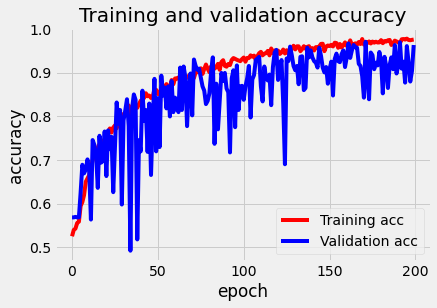

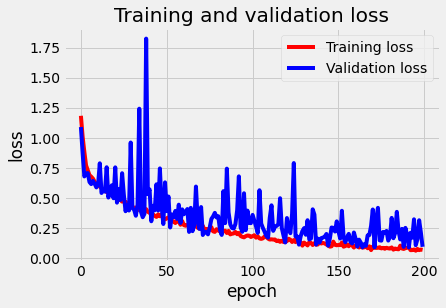

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Graphing our training and validation
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('plotting akurasi model resnet50_b64.png')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('plotting loss model resnet50_b64.png')
plt.show()


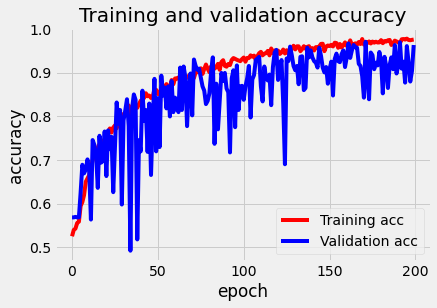

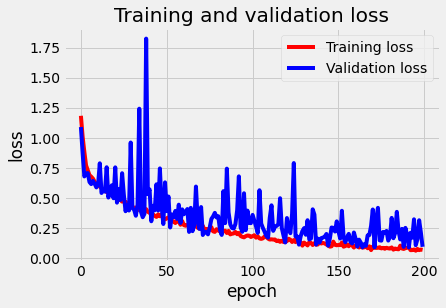

In [21]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Graphing our training and validation
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.savefig('plotting akurasi model mobilenet_b64.png')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.savefig('plotting loss model Resnet_b16.png')
plt.show()


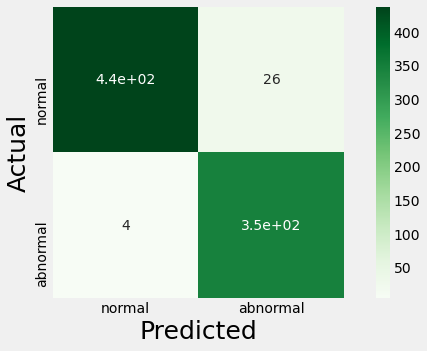

In [22]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10, 5))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=25)
ax.set_xlabel('Predicted', fontsize=25)
plt.savefig('cm model mobilenet_b64.png')

Confusion Matrix
[[437  26]
 [  4 347]]


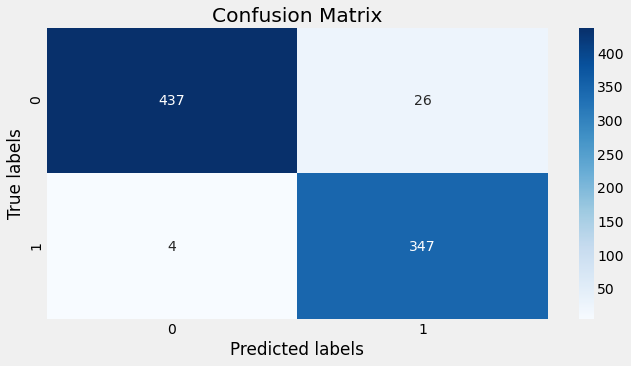

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import seaborn as sns

Y_true = np.argmax(Y_val, axis=1)
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(Y_true, Y_pred)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt=".0f")

# labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
plt.savefig('cm model resnet50_16blue.png')

# ticks
# ax.xaxis.set_ticklabels(list(test_generator.class_indices.keys()))
# ax.yaxis.set_ticklabels(list(test_generator.class_indices.keys()))
plt.show()


In [24]:
tp = cm[0,0]
tn = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
#print(cm)

precision = tp / ( tp + fp)
recall = tp/(tp+fn)
spesifisitas = tn / (tn+fp)
f1=(2*precision*recall)/ (precision+recall)
akurasi = (tp+tn)/(tp+tn+fp+fn)
all_hasil = [recall,precision,spesifisitas,akurasi,f1]

print ("presisi : ",precision*100)
print ("spesifisitas : ",spesifisitas*100)
print("recall : ",recall*100)
print ("F1 : ",f1*100)
print("akurasi : ",akurasi*100)

presisi :  94.38444924406048
spesifisitas :  93.02949061662198
recall :  99.09297052154194
F1 :  96.68141592920354
akurasi :  96.31449631449631


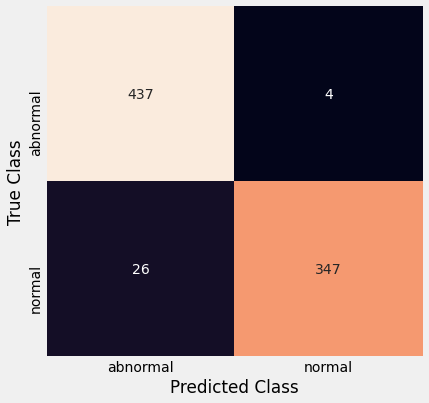

In [25]:
import seaborn as sns
cm = [[tp, fn], [fp, tn]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False, xticklabels=['abnormal', 'normal'], yticklabels = ['abnormal', 'normal'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.savefig('cm model resnet50_16.png')
plt.show()

In [26]:
from keras.models import load_model
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Uji Kesesuaian 1

[0.03067831 0.9693217 ]


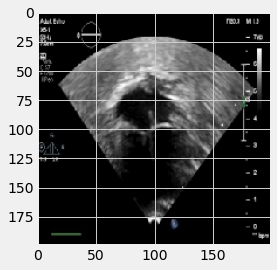

Prediksi
Prediction: abnormal



In [27]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/ADZKIYA_4CH_25.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/ADZKIYA_4CH_25.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.06389539 0.93610466]


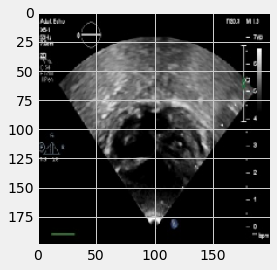

Prediksi
Prediction: abnormal



In [28]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/ADZKIYA_SUBCOSTAL_20.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/ADZKIYA_SUBCOSTAL_20.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.09112722 0.90887284]


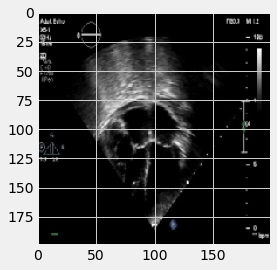

Prediksi
Prediction: abnormal



In [29]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Alif_Udin_4ch_5.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Alif_Udin_4ch_5.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.31778362 0.6822164 ]


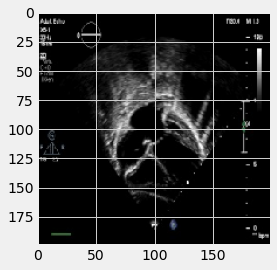

Prediksi
Prediction: abnormal



In [30]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Alif_Udin_subcostal_10.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Alif_Udin_subcostal_10.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.00109333 0.9989066 ]


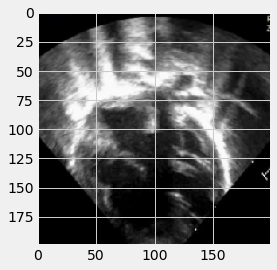

Prediksi
Prediction: abnormal



In [31]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/AZKA_4CH_0.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/AZKA_4CH_0.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.01434452 0.9856554 ]


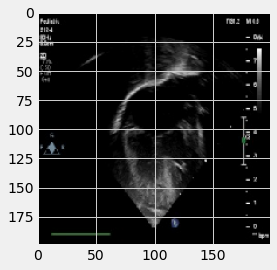

Prediksi
Prediction: abnormal



In [32]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Gabriela_4CH_41.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/Gabriela_4CH_41.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.03158259 0.9684174 ]


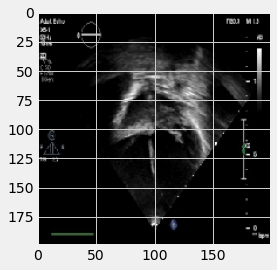

Prediksi
Prediction: abnormal



In [33]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/HARIS_ALHAFIZ_MOD2_5CH_37.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/HARIS_ALHAFIZ_MOD2_5CH_37.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.09905885 0.90094113]


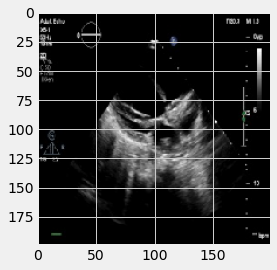

Prediksi
Prediction: abnormal



In [34]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/HARIS_ALHAFIZ_MOD2_LONG_AXIS_7.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/HARIS_ALHAFIZ_MOD2_LONG_AXIS_7.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.05683312 0.94316685]


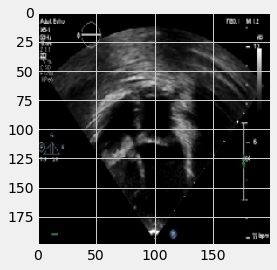

Prediksi
Prediction: abnormal



In [35]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/JUAN_5CH_4.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/JUAN_5CH_4.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.6939232  0.30607682]


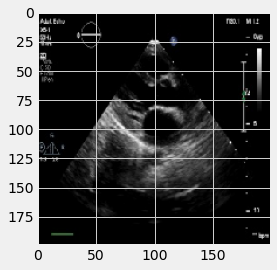

Prediksi
Prediction: normal



In [36]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/JUAN_LONG_AXIS_18.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/abnormal/JUAN_LONG_AXIS_18.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



# NORMAL

[0.02197521 0.97802484]


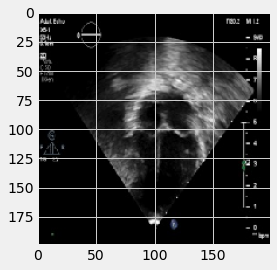

Prediksi
Prediction: abnormal



In [37]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/ZILKAN_ARGANANTA_4CH_0.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/ZILKAN_ARGANANTA_4CH_0.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.81911194 0.18088803]


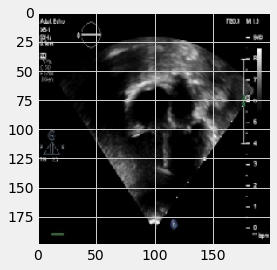

Prediksi
Prediction: normal



In [38]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/ZAFIRA_4CH_10.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/ZAFIRA_4CH_10.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.43350038 0.56649965]


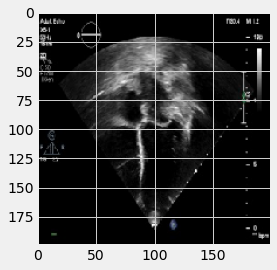

Prediksi
Prediction: abnormal



In [39]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/RISKI_ANGGA_4CH_3.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 1/all 260/normal/RISKI_ANGGA_4CH_3.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



# Uji Kesesuaian 2

# Abnormal

[0.02710595 0.9728941 ]


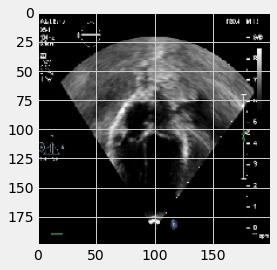

Prediksi
Prediction: abnormal



In [40]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_4CH_20.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_4CH_20.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.01837539 0.98162466]


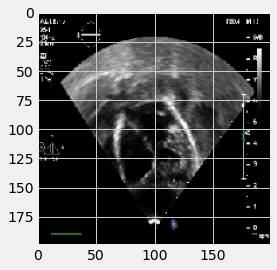

Prediksi
Prediction: abnormal



In [41]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_SUB_58.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_SUB_58.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02628961 0.97371036]


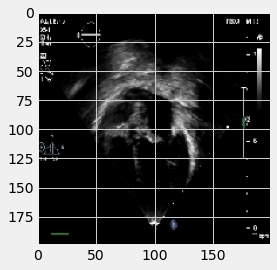

Prediksi
Prediction: abnormal



In [42]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AMI ALMAIRA (VSD) 5CH_14.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AMI ALMAIRA (VSD) 5CH_14.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.86885256 0.13114747]


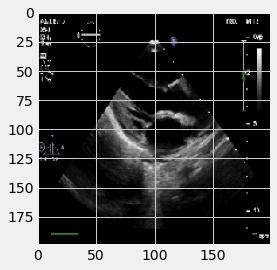

Prediksi
Prediction: normal



In [43]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AMI ALMAIRA (VSD) LA_22.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AMI ALMAIRA (VSD) LA_22.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.96243006 0.03756995]


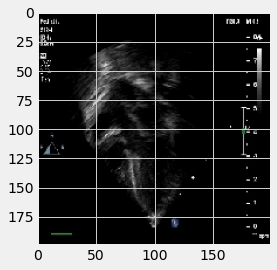

Prediksi
Prediction: normal



In [44]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ARCELIO RAYYAN (VSD)5CH_13.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ARCELIO RAYYAN (VSD)5CH_13.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.5640076 0.4359924]


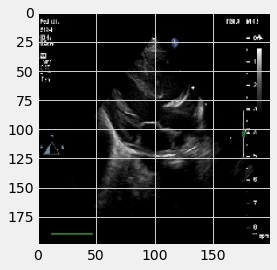

Prediksi
Prediction: normal



In [45]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ARCELIO RAYYAN (VSD)LA_28.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ARCELIO RAYYAN (VSD)LA_28.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02710595 0.9728941 ]


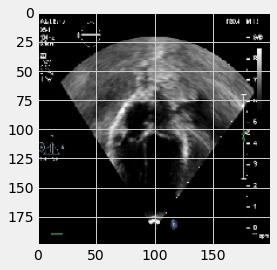

Prediksi
Prediction: abnormal



In [46]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_4CH_20.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ALULA_RIZKI_4CH_20.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.01359839 0.9864016 ]


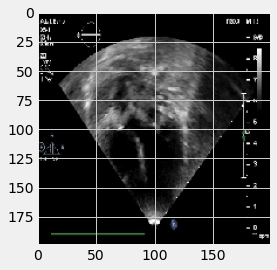

Prediksi
Prediction: abnormal



In [47]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ATHALLA KEANU ALFAREZI (VSD)5CH_83.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ATHALLA KEANU ALFAREZI (VSD)5CH_83.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.00178891 0.99821115]


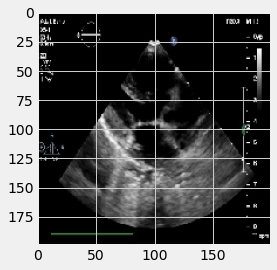

Prediksi
Prediction: abnormal



In [48]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ATHALLA KEANU ALFAREZI (VSD)LA_72.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ATHALLA KEANU ALFAREZI (VSD)LA_72.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.43045616 0.5695439 ]


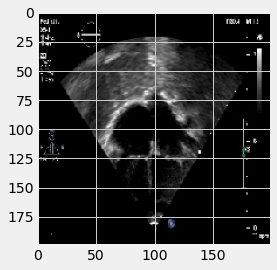

Prediksi
Prediction: abnormal



In [49]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA RAFASYAH_ 4CH_0.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA RAFASYAH_ 4CH_0.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.00447886 0.9955212 ]


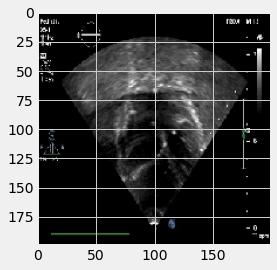

Prediksi
Prediction: abnormal



In [50]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA RAFASYAH_SUB_156.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA RAFASYAH_SUB_156.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[5.632143e-04 9.994368e-01]


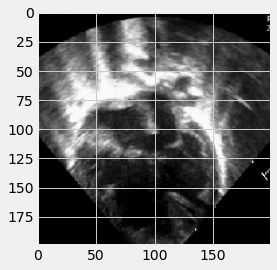

Prediksi
Prediction: abnormal



In [51]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA_4CH_4.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/AZKA_4CH_4.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02687458 0.97312546]


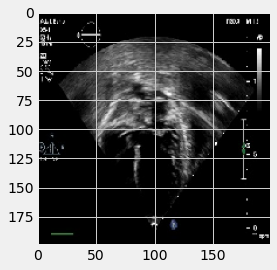

Prediksi
Prediction: abnormal



In [52]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/BALQISk_5CH_18.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/BALQISk_5CH_18.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.26710144 0.7328986 ]


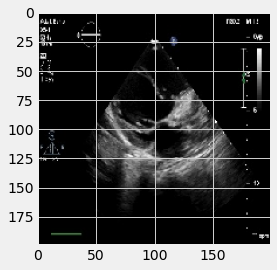

Prediksi
Prediction: abnormal



In [53]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/BALQISk_LONG_AXIS_26.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/BALQISk_LONG_AXIS_26.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02467334 0.97532666]


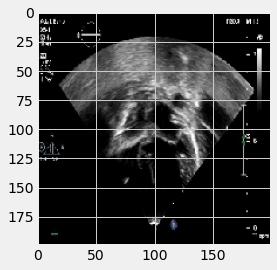

Prediksi
Prediction: abnormal



In [54]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/M AQIL ROBBANI (VSD)5CH_4.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/M AQIL ROBBANI (VSD)5CH_4.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.90517706 0.09482294]


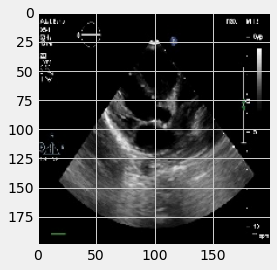

Prediksi
Prediction: normal



In [55]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/M AQIL ROBBANI (VSD)LA_11.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/M AQIL ROBBANI (VSD)LA_11.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.39226118 0.6077388 ]


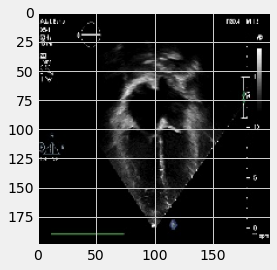

Prediksi
Prediction: abnormal



In [56]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/MARDITOTILA (ASD) 4CH_64.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/MARDITOTILA (ASD) 4CH_64.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.9781789 0.0218211]


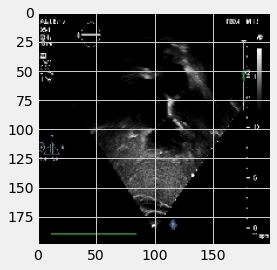

Prediksi
Prediction: normal



In [57]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/MARDITOTILA (ASD) SUB_76.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/MARDITOTILA (ASD) SUB_76.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.98282087 0.01717916]


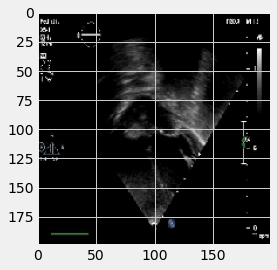

Prediksi
Prediction: normal



In [58]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/RIFQI ANAFI (VSD KESESUAIAN) 5CH_34.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/RIFQI ANAFI (VSD KESESUAIAN) 5CH_34.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.8433926  0.15660736]


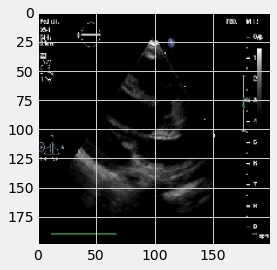

Prediksi
Prediction: normal



In [59]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/RIFQI ANAFI (VSD KESESUAIAN) LA_62.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/RIFQI ANAFI (VSD KESESUAIAN) LA_62.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.01889363 0.9811064 ]


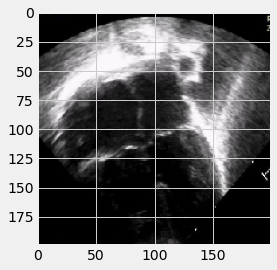

Prediksi
Prediction: abnormal



In [60]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/TITIS_4CH_41.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/TITIS_4CH_41.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.77691084 0.22308919]


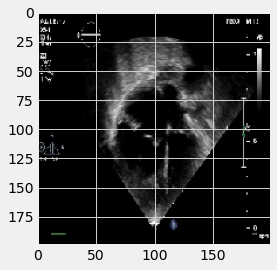

Prediksi
Prediction: normal



In [61]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/UTARI APRILIA (ASD) 4CH_11.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/UTARI APRILIA (ASD) 4CH_11.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02354441 0.9764556 ]


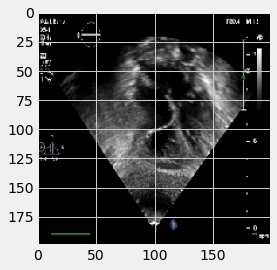

Prediksi
Prediction: abnormal



In [62]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/UTARI APRILIA (ASD) SUB_34.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/UTARI APRILIA (ASD) SUB_34.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.22304288 0.77695715]


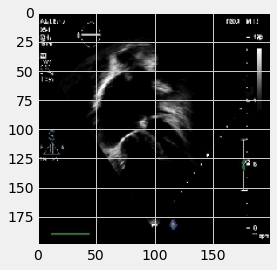

Prediksi
Prediction: abnormal



In [63]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/VIVI JULIA (ASD) 4CH_33.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/VIVI JULIA (ASD) 4CH_33.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.02899768 0.9710023 ]


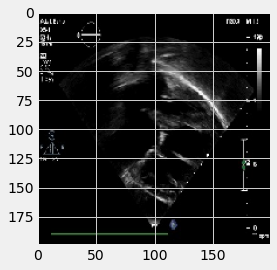

Prediksi
Prediction: abnormal



In [64]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/VIVI JULIA (ASD) SUB_104.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/VIVI JULIA (ASD) SUB_104.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.05322255 0.9467774 ]


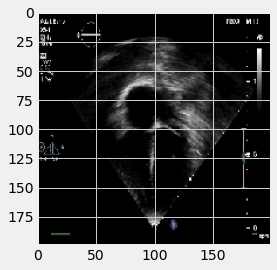

Prediksi
Prediction: abnormal



In [65]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ZAIRA_AURELLIA_4CH_16.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ZAIRA_AURELLIA_4CH_16.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.1030909 0.8969091]


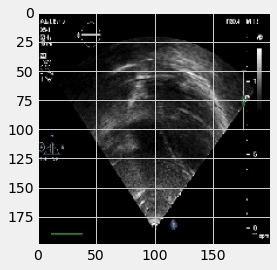

Prediksi
Prediction: abnormal



In [66]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ZAIRA_AURELLIA_SUB_27.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/abnormal/ZAIRA_AURELLIA_SUB_27.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



# Normal

[0.9521542  0.04784576]


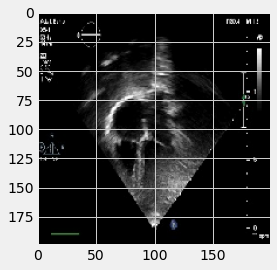

Prediksi
Prediction: normal



In [67]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/ABDUL HAKAM (NORMAL)4CH_24.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/ABDUL HAKAM (NORMAL)4CH_24.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.12958235 0.8704176 ]


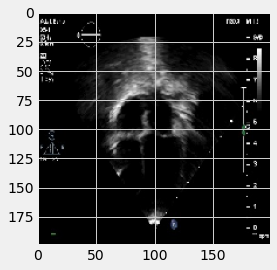

Prediksi
Prediction: abnormal



In [68]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/AISHWA_NADHIFA_4CH_2.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/AISHWA_NADHIFA_4CH_2.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.14248145 0.8575185 ]


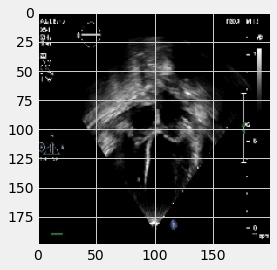

Prediksi
Prediction: abnormal



In [69]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/ASPALELA (NORMAL)4CH_9.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/ASPALELA (NORMAL)4CH_9.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.05808806 0.9419119 ]


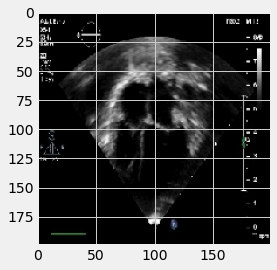

Prediksi
Prediction: abnormal



In [70]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/DAFFA_4CH_29.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/DAFFA_4CH_29.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.2932144 0.7067856]


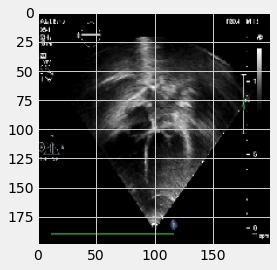

Prediksi
Prediction: abnormal



In [71]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/HAFIDZAH_4CH_109.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/HAFIDZAH_4CH_109.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()



[0.98693526 0.0130648 ]


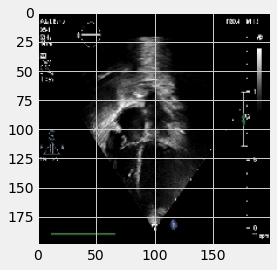

Prediksi
Prediction: normal



In [72]:
img = image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/PUTRI_VIOLA_4CH_56.jpg', grayscale=False, target_size=(64, 64))
show_img=image.load_img('F:/Project Prof Siti/dr Ria Nova/03 Klasifikasi/data1/Uji Kesesuaian 2/all 260/normal/PUTRI_VIOLA_4CH_56.jpg', grayscale=False, target_size=(200, 200))
disease_class=['normal','abnormal']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
print('Prediksi')
print('Prediction:',disease_class[ind])
print()

